In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!rm -rf /content/young_face_age
!rm -rf /content/old_face_age
!rm -rf /content/face_age
!kaggle datasets download -d frabbisw/facial-age

!unzip /content/facial-age
!rm -rf /content/face_age/face_age

In [2]:
directory = os.fsencode("/content/face_age")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filename_int = int(filename)
    if filename_int <= 40 and filename_int >= 20:
      !mv /content/face_age/{filename} /content/young_face_age
    elif filename_int >= 70:
      !mv /content/face_age/{filename} /content/old_face_age

directory = os.fsencode("/content/young_face_age")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"):
      !rm /content/young_face_age/{filename}

directory = os.fsencode("/content/old_face_age")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"):
      !rm /content/old_face_age/{filename}

# Import statements and initializing the data formatting

In [3]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
from torchvision.transforms import functional as T
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import itertools
import time

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((286, 286)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop((280, 280)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

young_face_data = torchvision.datasets.ImageFolder(root="./young_face_age", transform=transform)
old_face_data = torchvision.datasets.ImageFolder(root="./old_face_age", transform=transform)


batch_size = 32

# Define the train/test split ratio
train_ratio = 0.8
test_ratio = 1 - train_ratio
young_dataset_size = len(young_face_data)
old_dataset_size = len(old_face_data)

#Calculate the number of samples for each split
young_train_size = int(train_ratio * young_dataset_size)
young_test_size = young_dataset_size - young_train_size

old_train_size = int(train_ratio * old_dataset_size)
old_test_size = old_dataset_size - old_train_size

#Use random_split to create train and test datasets
young_train_dataset, young_test_dataset = torch.utils.data.random_split(young_face_data, [young_train_size, young_test_size])
old_train_dataset, old_test_dataset = torch.utils.data.random_split(old_face_data, [old_train_size, old_test_size])

#Define dataloaders for train and test datasets

young_face_train_loader = torch.utils.data.DataLoader(young_face_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)
young_face_test_loader = torch.utils.data.DataLoader(young_face_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)

old_face_train_loader = torch.utils.data.DataLoader(old_face_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)
old_face_test_loader = torch.utils.data.DataLoader(old_face_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model Definitions

In [6]:
### Generator Model
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    """The Generator model relies on central layers of ResBlocks,
      or residual blocks, which have two convolutional layers sandwiching
      normalization and ReLU activation layers."""
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    """The Generator model includes downsampling layers, 6 ResBlocks,
      and upsampling layers, alongside various normalization
      and ReLU activation layers."""
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

In [7]:
nc=3
ndf=64
class Discriminator(nn.Module):
    """The Discriminator Model utilizes a variety of rough blocks of
      convolutional, normalization, and ReLU activation layers to output
      a single-channel feature map, processing input images and returning scalar
      values indicating the likelihood that the input image is fake."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

# Loss functions

In [8]:
# Loss function for the Discriminator model
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

# Loss function for the Generator model
def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

LAMBDA = 10

# Cycle loss formula
def calc_cycle_loss(real_image, cycled_image):
  loss1 = torch.mean(torch.abs(real_image - cycled_image))

  return LAMBDA * loss1

# Identity loss formula
def identity_loss(real_image, same_image):
  loss = torch.mean(torch.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# Train and Test Loops

In [9]:
def train_step(gen1, disc1, gen2, disc2, gen_opt, disc_opt, g_scale_loss, d_scale_loss, real_x, real_y):
  real_x = real_x.to("cuda")
  real_y = real_y.to("cuda")
  with torch.cuda.amp.autocast():
    fake_y = gen1.forward(real_x)
    fake_x = gen2.forward(real_y)

    disc_real_x = disc1.forward(real_x)
    disc_real_y = disc2.forward(real_y)

    disc_fake_x = disc1.forward(fake_x)
    disc_fake_y = disc2.forward(fake_y)

    disc_x_loss = LSGAN_D(disc_real_x, disc_fake_x)
    disc_y_loss = LSGAN_D(disc_real_y, disc_fake_y)
    total_disc_loss = (disc_x_loss + disc_y_loss) / 2

  #Backpropagation for discriminator optimizer
  disc_opt.zero_grad()
  d_scale_loss.scale(total_disc_loss).backward(retain_graph=True)
  d_scale_loss.step(disc_opt)
  d_scale_loss.update()

  with torch.cuda.amp.autocast():
    # forward pass
    cycled_x = gen2.forward(fake_y)
    cycled_y = gen1.forward(fake_x)

    # same_x and same_y are used for identity loss.
    same_x = gen2.forward(real_x)
    same_y = gen1.forward(real_y)


    # calculate the loss
    gen_1_loss = LSGAN_G(disc_fake_y)
    gen_2_loss = LSGAN_G(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_1_loss = gen_1_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_2_loss = gen_2_loss + total_cycle_loss + identity_loss(real_x, same_x)
    total_gen_loss = gen_1_loss + gen_2_loss + total_cycle_loss

  #Backpropagation for generator optimizer
  gen_opt.zero_grad()
  g_scale_loss.scale(total_gen_loss).backward()
  g_scale_loss.step(gen_opt)
  g_scale_loss.update()

In [20]:
# Initializing test images as constants
sample_young = next(iter(young_face_test_loader))
sample_old = next(iter(old_face_test_loader))
num_iterations_per_epoch = len(old_face_train_loader)

# Training function
def train(gen1, disc1, gen2, disc2, gen_opt, disc_opt, g_scale_loss, d_scale_loss, epochs):
  start_time = time.time()
  # Iterating through epochs
  for epoch in range(epochs):
    epoch_start_time = time.time()
    gen1.train()
    gen2.train()
    disc1.train()
    disc2.train()
    dataloader_iterator = iter(young_face_train_loader)
    last_iter = 0

    # Iterating through batches
    for i, data1 in enumerate(old_face_train_loader):
        try:
            data2 = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(young_face_train_loader)
            data2 = next(dataloader_iterator)
        for j in range(len(data1[0])):
          train_step(gen1, disc1, gen2, disc2, gen_opt, disc_opt, g_scale_loss, d_scale_loss, data1[0][j], data2[0][j])

          # Print time check
          if time.time() - start_time >= 300:  # 300 seconds = 5 minutes
            elapsed_time = time.time() - start_time
            remaining_time = elapsed_time / (i + 1 - last_iter) * (num_iterations_per_epoch - i - 1)
            print(f"Epoch [{epoch+1}/{epochs}], Iteration [{i+1}/{num_iterations_per_epoch}], "
                  f"Time Elapsed: {elapsed_time:.2f}s, Time Remaining: {remaining_time:.2f}s")
            start_time = time.time()
            last_iter = i

        if i % 100 == 0:
          print(f"Epoch: {epoch}, Batch: {i}")

          generate_images(gen2, sample_young[0].to("cuda"))
          generate_images(gen1, sample_old[0].to("cuda"))

    # Print timing of epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{epochs}] completed in {epoch_duration:.2f}s")


    # Save models to drive
    model_save_name1 = 'gen1_epoch' + str(epoch+load_epoch) + '.pt'
    path1 = F"/content/gdrive/My Drive/{model_save_name1}"
    model_save_name2 = 'gen2_epoch' + str(epoch+load_epoch) + '.pt'
    path2 = F"/content/gdrive/My Drive/{model_save_name2}"
    model_save_name3 = 'disc1_epoch' + str(epoch+load_epoch) + '.pt'
    path3 = F"/content/gdrive/My Drive/{model_save_name3}"
    model_save_name4 = 'disc2_epoch' + str(epoch+load_epoch) + '.pt'
    path4 = F"/content/gdrive/My Drive/{model_save_name4}"
    torch.save(gen1.state_dict(), path1)
    torch.save(gen2.state_dict(), path2)
    torch.save(disc1.state_dict(), path3)
    torch.save(disc2.state_dict(), path4)

    test(gen1, disc1, gen2, disc2, 10)
    print("Epoch" + str(epoch))

In [11]:
def test_step(gen1, disc1, gen2, disc2, real_x, real_y):
    real_x = real_x.to("cuda")
    real_y = real_y.to("cuda")

    with torch.no_grad():
        fake_y = gen1.forward(real_x)
        fake_x = gen2.forward(real_y)

        disc_real_x = disc1.forward(real_x)
        disc_real_y = disc2.forward(real_y)
        disc_fake_x = disc1.forward(fake_x)
        disc_fake_y = disc2.forward(fake_y)

        disc_x_loss = LSGAN_D(disc_real_x, disc_fake_x)
        disc_y_loss = LSGAN_D(disc_real_y, disc_fake_y)
        total_disc_loss = (disc_x_loss + disc_y_loss) / 2

        cycled_x = gen2.forward(fake_y)
        cycled_y = gen1.forward(fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        same_x = gen2.forward(real_x)
        same_y = gen1.forward(real_y)

        gen_1_loss = LSGAN_G(disc_fake_y)
        gen_2_loss = LSGAN_G(disc_fake_x)

        total_gen_1_loss = gen_1_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_2_loss = gen_2_loss + total_cycle_loss + identity_loss(real_x, same_x)
        total_gen_loss = gen_1_loss + gen_2_loss + total_cycle_loss

    return total_gen_loss, total_disc_loss


In [12]:
def test(gen1, disc1, gen2, disc2, num_iterations):
    gen1.eval()
    gen2.eval()
    disc1.eval()
    disc2.eval()

    total_gen_loss = 0.0
    total_disc_loss = 0.0

    # Test loss
    for i in range(num_iterations):
        with torch.no_grad():
            sample_young = next(iter(young_face_test_loader))
            sample_old = next(iter(old_face_test_loader))
            data1 = next(iter(old_face_test_loader))
            data2 = next(iter(young_face_test_loader))
            gen_loss, disc_loss = test_step(gen1, disc1, gen2, disc2, data1[0][0].to("cuda"), data2[0][0].to("cuda"))
            total_gen_loss += gen_loss.item()
            total_disc_loss += disc_loss.item()
            # Test young to old
            gen_test_grid(gen2, data2[0].to("cuda"), "y2o")
            # Test old to young
            gen_test_grid(gen1, data1[0].to("cuda"), "o2y")

            if i % 100 == 0:
                print(f"Iteration [{i+1}/{num_iterations}], "
                      f"Average Generator Loss: {total_gen_loss / (i+1):.4f}, "
                      f"Average Discriminator Loss: {total_disc_loss / (i+1):.4f}")

    average_gen_loss = total_gen_loss / num_iterations
    average_disc_loss = total_disc_loss / num_iterations
    print(f"Average Generator Loss: {average_gen_loss:.4f}")
    print(f"Average Discriminator Loss: {average_disc_loss:.4f}")


# Initializing/Loading Values and Models

In [13]:
# Set parameters
lr = 0.00002
b1 = 0.5
b2 = 0.999

from google.colab import drive
drive.mount('/content/gdrive')


# Initialize generator and discriminator models
gen1 = Generator()
disc1 = Discriminator()
gen2 = Generator()
disc2 = Discriminator()

# Set the number of the epoch to load
load_epoch = 15
try:
  gen1.load_state_dict(torch.load(f"/content/gdrive/My Drive/gen1_epoch{load_epoch}.pt"), strict=False)
  disc1.load_state_dict(torch.load(f"/content/gdrive/My Drive/disc1_epoch{load_epoch}.pt"), strict=False)
  gen2.load_state_dict(torch.load(f"/content/gdrive/My Drive/gen2_epoch{load_epoch}.pt"), strict=False)
  disc2.load_state_dict(torch.load(f"/content/gdrive/My Drive/disc2_epoch{load_epoch}.pt"), strict=False)
except:
  try:
    gen1.load_state_dict(torch.load(f"/gen1_epoch{load_epoch}.pt"), strict=False)
    disc1.load_state_dict(torch.load(f"/disc1_epoch{load_epoch}.pt"), strict=False)
    gen2.load_state_dict(torch.load(f"/gen2_epoch{load_epoch}.pt"), strict=False)
    disc2.load_state_dict(torch.load(f"/disc2_epoch{load_epoch}.pt"), strict=False)
  except:
    print("No models found to load. Proceeding from scratch.")
    load_epoch = 0

gen1.cuda()
gen2.cuda()
disc1.cuda()
disc2.cuda()
gen_opt = optim.Adam(
    itertools.chain(gen1.parameters(), gen2.parameters()), lr=lr, betas=(b1,b2))

disc_opt = optim.Adam(
    itertools.chain(disc1.parameters(), disc2.parameters()), lr=lr, betas=(b1,b2)
)

g_scale_loss = torch.cuda.amp.GradScaler()
d_scale_loss = torch.cuda.amp.GradScaler()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Functions for image generation

In [14]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))
  display_list = [test_input[0].permute(1, 2, 0), prediction[0].detach().permute(1, 2, 0)]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i].cpu() * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [22]:
def gen_test_grid(model, test_input, direction = ""):
    predictions = model(test_input)

    plt.figure(figsize=(20, 30))
    num_rows = 8
    num_cols = 4
    # Determine direction of the generative model
    if direction == "y2o":
      title_input = "Young Input Image"
      title_predicted = "Old Predicted Image"
      title = "Generating Old Faces based on Young Faces"
    elif direction == "o2y":
      title_input = "Old Input Image"
      title_predicted = "Young Predicted Image"
      title = "Generating Young Faces based on Old Faces"
    else:
      title_input = "Input Image"
      title_predicted = "Predicted Image"
      title = ""

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(test_input):
                plt.subplot(num_rows, 2*num_cols, 2*index + 1)
                plt.title(title_input)
                plt.imshow(test_input[index].permute(1, 2, 0).cpu() * 0.5 + 0.5)
                plt.axis('off')

                plt.subplot(num_rows, 2*num_cols, 2*index + 2)
                plt.title(title_predicted)
                plt.imshow(predictions[index].detach().permute(1, 2, 0).cpu() * 0.5 + 0.5)
                plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


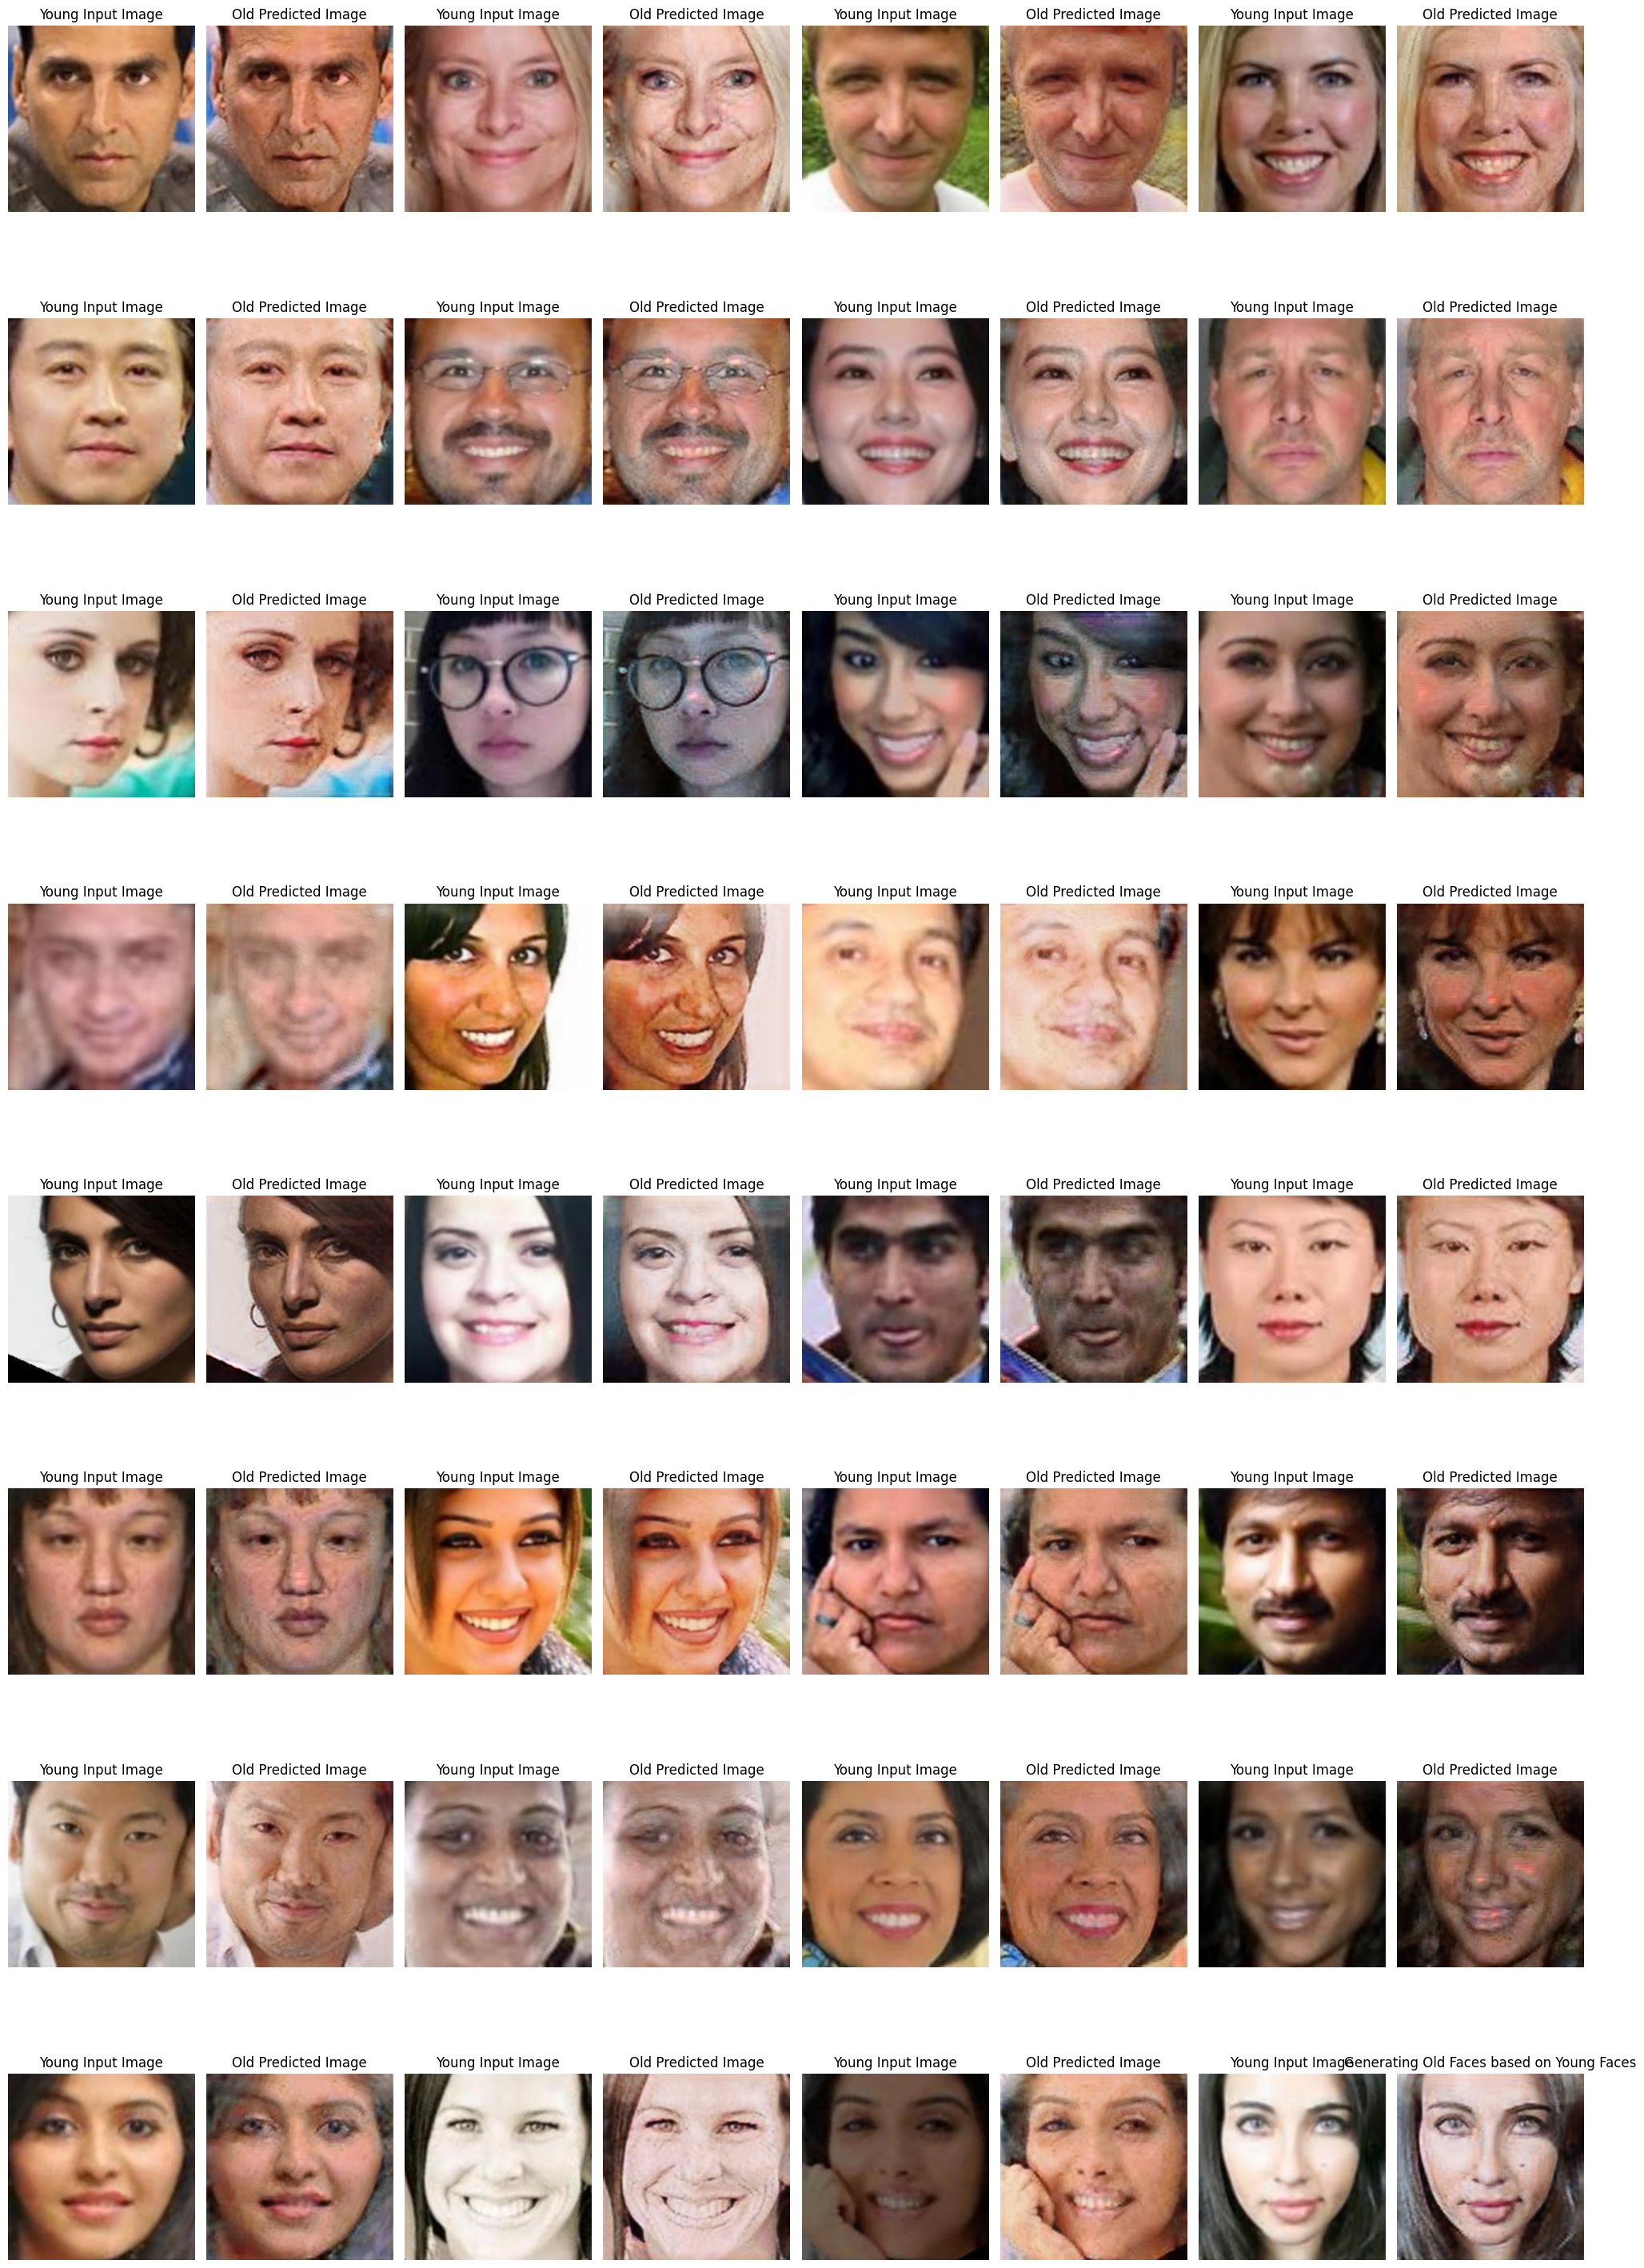

In [25]:
data_test = next(iter(young_face_test_loader))
gen_test_grid(gen2, data_test[0].to("cuda"), "y2o")

In [ ]:
torch.autograd.set_detect_anomaly(True)
## Running the training loop for 20 epochs
train(gen1, disc1, gen2, disc2, gen_opt, disc_opt, g_scale_loss, d_scale_loss, 20)